In [1]:
# ============================================
# 🧠 Customer Marketing Reinforcement Learning
# ============================================

import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from collections import deque
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.preprocessing import LabelEncoder


In [3]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

# -------------------------------
# Parameters
# -------------------------------
num_customers = 100
max_events_per_customer = 10

# Define campaigns and their base conversion rates
campaigns = {
    "Email Promo": 0.15,
    "SMS Offer": 0.20,
    "Call": 0.25,
    "No Action": 0.0
}

# Action to channel mapping
action_to_channel = {
    "Email Promo": "Email",
    "SMS Offer": "SMS",
    "Call": "Call",
    "No Action": "None"
}

# Fatigue and reward penalty
fatigue_penalty_per_repeat = 0.03
reward_penalty_per_fatigue = 0.5

# -------------------------------
# Step 1: Generate Customer Profiles
# -------------------------------
locations = ['Mumbai', 'Delhi', 'Bangalore', 'Chennai']
products = ['Credit Card', 'Loan', 'Savings Account', 'Insurance']

profile_data = []
for i in range(num_customers):
    profile_data.append({
        "customer_id": f"C{i:03d}",
        "age": random.randint(22, 60),
        "gender": random.choice(['M', 'F']),
        "location": random.choice(locations),
        "salary": random.randint(30000, 150000),
        "product_owned": random.choice(products)
    })

df_profiles = pd.DataFrame(profile_data)
df_profiles.to_csv("customer_profiles.csv", index=False)

# -------------------------------
# Step 2: Create Campaign Metadata
# -------------------------------
df_campaigns = pd.DataFrame([
    {"action_name": k, "base_conversion_rate": v} for k, v in campaigns.items()
])
df_campaigns.to_csv("campaign_metadata.csv", index=False)

# -------------------------------
# Step 3: Define Reward Function
# -------------------------------
def compute_reward(responded, converted, fatigue_count, action_taken):
    if action_taken == "No Action":
        return 0.0
    if converted:
        base = 20.0  # High reward for conversion
    elif responded:
        base = 2.0
    else:
        base = -1.0
    penalty = fatigue_count * reward_penalty_per_fatigue
    return max(base - penalty, -5.0)

# -------------------------------
# Step 4: Generate Customer Events
# -------------------------------
event_types = ['click', 'visit', 'purchase', 'login']
all_events = []

for customer in df_profiles['customer_id']:
    fatigue_counter = {action: 0 for action in campaigns}
    channel_fatigue = {"Email": 0, "SMS": 0, "Call": 0, "None": 0}
    
    start_time = datetime(2023, 6, 1)
    last_time = start_time

    for step in range(max_events_per_customer):
        action = random.choices(list(campaigns.keys()), weights=[0.4, 0.3, 0.2, 0.1])[0]
        base_rate = campaigns[action]
        fatigue = fatigue_counter[action]
        adjusted_rate = max(base_rate - fatigue_penalty_per_repeat * fatigue, 0.01)

        responded = 1 if random.random() < adjusted_rate + 0.1 else 0
        converted = 1 if random.random() < adjusted_rate else 0

        # Time handling
        if step == 0:
            gap_days = 0
            event_time = start_time
        else:
            gap_days = random.randint(1, 5)
            event_time = last_time + timedelta(days=gap_days)
        last_time = event_time

        # Other event data
        event_type = random.choice(event_types)
        amount = random.randint(100, 2000) if event_type == 'purchase' else 0

        reward = compute_reward(responded, converted, fatigue, action)
        channel = action_to_channel[action]

        all_events.append({
            "customer_id": customer,
            "timestamp": event_time.strftime('%Y-%m-%d %H:%M:%S'),
            "event_type": event_type,
            "amount": amount,
            "action_taken": action,
            "channel": channel,
            "responded": responded,
            "converted": converted,
            "fatigue_count": fatigue,
            "gap_days": gap_days,
            "reward": round(reward, 2)
        })

        # Update fatigue trackers
        fatigue_counter[action] += 1
        channel_fatigue[channel] += 1

        if converted == 1:
            break  # Stop on conversion

# Save all events
df_events = pd.DataFrame(all_events)
df_events.to_csv("customer_events.csv", index=False)

print("✅ Synthetic data generated with channel info and reward logic.")

✅ Synthetic data generated with channel info and reward logic.


In [4]:
df_events=pd.read_csv("customer_events.csv")
df_profiles=pd.read_csv("customer_profiles.csv")

In [5]:
df_events.head(20)

,customer_id,timestamp,event_type,amount,action_taken,channel,responded,converted,fatigue_count,gap_days,reward
0,C000,2023-06-01 00:00:00,login,0,Call,Call,1,1,0,0,20.0
1,C001,2023-06-01 00:00:00,visit,0,Call,Call,1,1,0,0,20.0
2,C002,2023-06-01 00:00:00,purchase,472,Email Promo,Email,0,0,0,0,-1.0
3,C002,2023-06-04 00:00:00,purchase,677,No Action,NaN,0,0,0,3,0.0
4,C002,2023-06-07 00:00:00,visit,0,SMS Offer,SMS,0,0,0,3,-1.0
5,C002,2023-06-11 00:00:00,visit,0,SMS Offer,SMS,0,0,1,4,-1.5
6,C002,2023-06-16 00:00:00,click,0,SMS Offer,SMS,0,1,2,5,19.0
7,C003,2023-06-01 00:00:00,purchase,1192,Email Promo,Email,0,0,0,0,-1.0
8,C003,2023-06-03 00:00:00,login,0,Email Promo,Email,0,1,1,2,19.5
9,C004,2023-06-01 00:00:00,login,0,No Action,NaN,1,0,0,0,0.0


In [6]:
df_events.tail(20)

,customer_id,timestamp,event_type,amount,action_taken,channel,responded,converted,fatigue_count,gap_days,reward
501,C098,2023-06-01 00:00:00,click,0,Email Promo,Email,1,0,0,0,2.0
502,C098,2023-06-04 00:00:00,visit,0,Email Promo,Email,0,0,1,3,-1.5
503,C098,2023-06-08 00:00:00,login,0,SMS Offer,SMS,1,0,0,4,2.0
504,C098,2023-06-13 00:00:00,purchase,318,SMS Offer,SMS,1,0,1,5,1.5
505,C098,2023-06-18 00:00:00,click,0,Email Promo,Email,0,0,2,5,-2.0
506,C098,2023-06-20 00:00:00,visit,0,No Action,NaN,0,0,0,2,0.0
507,C098,2023-06-25 00:00:00,click,0,Email Promo,Email,0,0,3,5,-2.5
508,C098,2023-06-27 00:00:00,click,0,Email Promo,Email,1,0,4,2,0.0
509,C098,2023-07-01 00:00:00,login,0,Call,Call,1,0,0,4,2.0
510,C098,2023-07-03 00:00:00,login,0,No Action,NaN,0,0,1,2,0.0


In [7]:
# -------------------------------
# Step 3: RL Setup
# -------------------------------
le_evt = LabelEncoder().fit(df_events["event_type"])
num_actions = len(campaigns)
profile_dim = 6

# Profile encoding
def encode_profile(row):
    gender = 1 if row["gender"] == "M" else 0
    loc = locations.index(row["location"])
    prod = products.index(row["product_owned"])
    return np.array([row["age"], gender, loc, row["salary"], prod, 1.0])

cust_to_profile = {r["customer_id"]: encode_profile(r) for _, r in df_profiles.iterrows()}


In [8]:
# -------------------------------
# Step 4: Environment Definition
# -------------------------------
class MarketingEnv:
    def __init__(self, campaigns, base_conversion, max_seq_len=10, fatigue_penalty=0.03):
        self.campaigns = list(campaigns.keys())
        self.base_conversion = campaigns
        self.max_seq_len = max_seq_len
        self.fatigue_penalty = fatigue_penalty
        self.reset()

    def reset(self, profile_vec=None):
        self.action_hist, self.event_type_hist, self.response_hist, self.conversion_hist = [], [], [], []
        self.fatigue = {a: 0 for a in self.campaigns}
        self.response_memory = 0.0
        self.steps, self.done = 0, False
        self.profile = np.zeros((profile_dim,), np.float32) if profile_vec is None else profile_vec
        return self._get_state()

    def _pad(self, seq, L, dtype):
        arr = np.zeros(L, dtype=dtype)
        n = min(len(seq), L)
        if n > 0:
            arr[:n] = np.asarray(seq[:n], dtype=dtype)
        return arr

    def _sample_event_type_id(self, responded, converted):
        if converted == 1.0:
            return le_evt.transform(["purchase"])[0]
        elif responded == 1.0:
            return le_evt.transform(["click"])[0]
        else:
            return le_evt.transform(["login"])[0]

    def _get_state(self):
        return (
            self._pad(self.action_hist, self.max_seq_len, np.int32),
            self._pad(self.event_type_hist, self.max_seq_len, np.int32),
            self._pad(self.response_hist, self.max_seq_len, np.float32),
            self._pad(self.conversion_hist, self.max_seq_len, np.float32),
            self.profile.astype(np.float32)
        )

    def step(self, action_idx):
        act_name = self.campaigns[action_idx]
        base_p = self.base_conversion.get(act_name, 0.01)
        adj = base_p + 0.1*self.response_memory - self.fatigue[act_name]*self.fatigue_penalty
        adj = np.clip(adj, 0.01, 0.9)
        responded = 1.0 if random.random() < adj+0.05 else 0.0
        converted = 1.0 if random.random() < adj else 0.0
        reward = 20.0 if converted==1.0 else (2.0 if responded==1.0 else -1.0)
        evt_id = self._sample_event_type_id(responded, converted)
        self.action_hist.append(int(action_idx))
        self.event_type_hist.append(int(evt_id))
        self.response_hist.append(float(responded))
        self.conversion_hist.append(float(converted))
        if act_name != "No Action": self.fatigue[act_name] += 1
        self.response_memory = 0.7*self.response_memory + 0.3*responded
        self.steps += 1
        self.done = bool(converted) or self.steps >= self.max_seq_len
        return self._get_state(), reward, self.done

env = MarketingEnv(campaigns, campaigns, max_seq_len=10)


In [9]:
# -------------------------------
# Step 5: Build Q-Network
# -------------------------------
def build_q_model(num_actions, max_seq_len, profile_dim, embed_dim=64):
    act_in = layers.Input((max_seq_len,), dtype='int32')
    evt_in = layers.Input((max_seq_len,), dtype='int32')
    rsp_in = layers.Input((max_seq_len,), dtype='float32')
    cnv_in = layers.Input((max_seq_len,), dtype='float32')
    prof_in = layers.Input((profile_dim,), dtype='float32')

    act_emb = layers.Embedding(num_actions, embed_dim)(act_in)
    evt_emb = layers.Embedding(len(le_evt.classes_), embed_dim)(evt_in)
    seq = layers.Concatenate()([act_emb, evt_emb,
                                layers.Reshape((max_seq_len,1))(rsp_in),
                                layers.Reshape((max_seq_len,1))(cnv_in)])
    seq = layers.Dense(embed_dim, activation='relu')(seq)
    seq = layers.GlobalAveragePooling1D()(seq)

    x = layers.Concatenate()([seq, prof_in])
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    out = layers.Dense(num_actions, activation='linear')(x)

    model = models.Model([act_in, evt_in, rsp_in, cnv_in, prof_in], out)
    model.compile(optimizer=optimizers.Adam(1e-3), loss='mse')
    return model

model = build_q_model(num_actions, 10, profile_dim)
target_model = build_q_model(num_actions, 10, profile_dim)
target_model.set_weights(model.get_weights())
print(model.summary())


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 10)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_1 (InputLayer)    │ (None, 10)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_2 (InputLayer)    │ (None, 10)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_3 (InputLayer)    │ (None, 10)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 10, 64)            │             256 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_1 (Embedding)       │ (None, 10, 64)            │             256 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape (Reshape)             │ (None, 10, 1)             │               0 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape_1 (Reshape)           │ (None, 10, 1)             │               0 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 10, 130)           │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding_1[0][0],         │
│                               │                           │                 │ reshape[0][0],             │
│                               │                           │                 │ reshape_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 10, 64)            │           8,384 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling1d      │ (None, 64)                │               0 │ dense[0][0]                │
│ (GlobalAveragePooling1D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_4 (InputLayer)    │ (None, 6)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 70)                │               0 │ global_average_pooling1d[… │
│                               │                           │                 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 128)               │           9,088 │ concatenate_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 64)                │           8,25

 Total params: 26,500 (103.52 KB)

 Trainable params: 26,500 (103.52 KB)

 Non-trainable params: 0 (0.00 B)

None


In [10]:
# -------------------------------
# Step 6: Training Loop
# -------------------------------
episodes = 15
gamma, epsilon, epsilon_min, epsilon_decay = 0.95, 1.0, 0.1, 0.995
batch_size = 64
replay = deque(maxlen=5000)
reward_log, loss_log, epsilon_log = [], [], []

cust_ids = list(cust_to_profile.keys())

for ep in range(episodes):
    cid = random.choice(cust_ids)
    prof_vec = cust_to_profile[cid]
    state = env.reset(profile_vec=prof_vec)
    total_reward, done = 0.0, False
    ep_losses = []

    while not done:
        act_seq, evt_seq, rsp_seq, cnv_seq, prof = [np.asarray(s) for s in state]
        act_seq, evt_seq = act_seq.astype(np.int32), evt_seq.astype(np.int32)
        rsp_seq, cnv_seq, prof = rsp_seq.astype(np.float32), cnv_seq.astype(np.float32), prof.astype(np.float32)
        rsp_seq, cnv_seq = rsp_seq.astype(float), cnv_seq.astype(float)

        if np.random.rand() < epsilon:
            action = np.random.randint(num_actions)
        else:
            q_pred = model.predict([act_seq[np.newaxis], evt_seq[np.newaxis],
                                    rsp_seq[np.newaxis], cnv_seq[np.newaxis],
                                    prof[np.newaxis]], verbose=0)
            action = int(np.argmax(q_pred[0]))

        next_state, reward, done = env.step(action)
        replay.append((state, action, reward, next_state, done))
        total_reward += reward
        state = next_state

        if len(replay) >= batch_size:
            batch = random.sample(replay, batch_size)
            a_act = np.array([b[0][0] for b in batch], np.int32)
            a_evt = np.array([b[0][1] for b in batch], np.int32)
            a_rsp = np.array([b[0][2] for b in batch], np.float32)
            a_cnv = np.array([b[0][3] for b in batch], np.float32)
            a_pro = np.array([b[0][4] for b in batch], np.float32)
            n_act = np.array([b[3][0] for b in batch], np.int32)
            n_evt = np.array([b[3][1] for b in batch], np.int32)
            n_rsp = np.array([b[3][2] for b in batch], np.float32)
            n_cnv = np.array([b[3][3] for b in batch], np.float32)
            n_pro = np.array([b[3][4] for b in batch], np.float32)
            a_idx = np.array([b[1] for b in batch], np.int32)
            r_mb = np.array([b[2] for b in batch], np.float32)
            d_mb = np.array([b[4] for b in batch], np.float32)

            q_curr = model.predict([a_act,a_evt,a_rsp,a_cnv,a_pro], verbose=0)
            q_next = target_model.predict([n_act,n_evt,n_rsp,n_cnv,n_pro], verbose=0)
            for i in range(batch_size):
                target = r_mb[i] if d_mb[i] else r_mb[i] + gamma * np.max(q_next[i])
                q_curr[i, a_idx[i]] = target

            loss = model.train_on_batch([a_act,a_evt,a_rsp,a_cnv,a_pro], q_curr)
            ep_losses.append(float(loss))

    target_model.set_weights(model.get_weights())
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    reward_log.append(total_reward)
    loss_log.append(np.mean(ep_losses) if ep_losses else 0.0)
    epsilon_log.append(epsilon)
    print(f"Ep {ep+1:03d}/{episodes} | Reward={total_reward:6.2f} | Loss={loss_log[-1]:.4f} | ε={epsilon:.3f}")


Ep 001/15 | Reward= 21.00 | Loss=0.0000 | ε=0.995
Ep 002/15 | Reward= -7.00 | Loss=0.0000 | ε=0.990
Ep 003/15 | Reward= 23.00 | Loss=0.0000 | ε=0.985
Ep 004/15 | Reward=-10.00 | Loss=0.0000 | ε=0.980
Ep 005/15 | Reward= -7.00 | Loss=0.0000 | ε=0.975
Ep 006/15 | Reward= 19.00 | Loss=0.0000 | ε=0.970
Ep 007/15 | Reward= 17.00 | Loss=0.0000 | ε=0.966
Ep 008/15 | Reward= 20.00 | Loss=0.0000 | ε=0.961
Ep 009/15 | Reward= 23.00 | Loss=0.0000 | ε=0.956
Ep 010/15 | Reward= 23.00 | Loss=914253.6094 | ε=0.951
Ep 011/15 | Reward= 17.00 | Loss=533779.6484 | ε=0.946
Ep 012/15 | Reward= 20.00 | Loss=519318.1562 | ε=0.942
Ep 013/15 | Reward= 22.00 | Loss=504139.2969 | ε=0.937
Ep 014/15 | Reward= -4.00 | Loss=490568.1344 | ε=0.932
Ep 015/15 | Reward= 19.00 | Loss=486706.0781 | ε=0.928


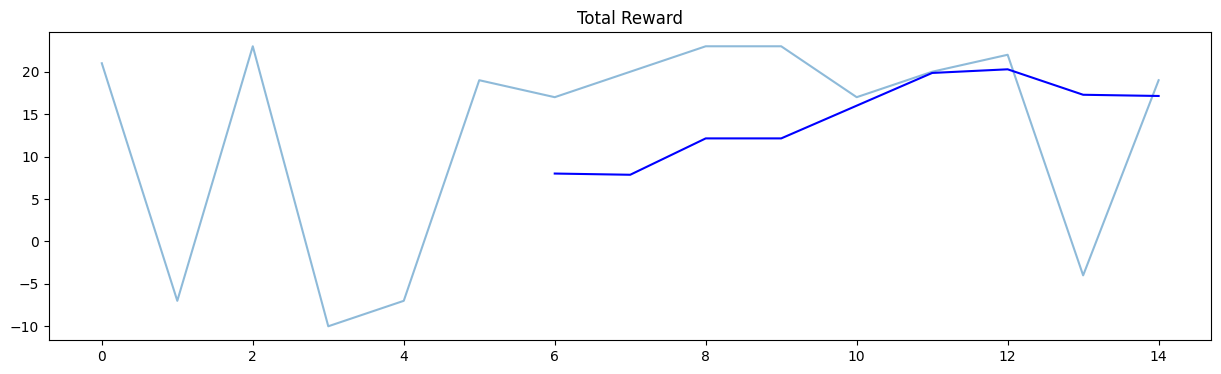

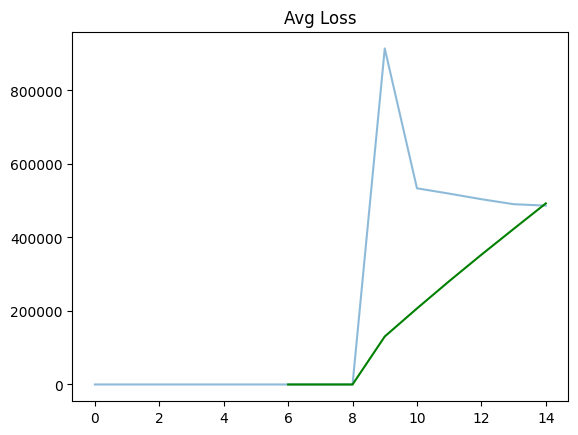

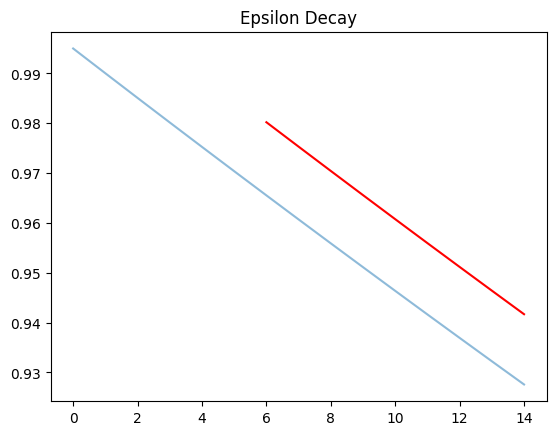

In [11]:
# -------------------------------
# Step 7: Training Visualization
# -------------------------------
def moving_average(x, w=7):
    if len(x) < w: return np.array(x, dtype=float)
    return np.convolve(x, np.ones(w)/w, mode='valid')

plt.figure(figsize=(15,4))
for data, title, color in zip([reward_log, loss_log, epsilon_log],
                              ["Total Reward", "Avg Loss", "Epsilon Decay"],
                              ['b','g','r']):
    plt.plot(data, alpha=0.5)
    plt.plot(np.arange(6, len(data)), moving_average(data), color=color)
    plt.title(title)
    plt.show()


In [13]:
# ============================================
# 🔮 Step 8: Prediction for New Customers
# ============================================

def predict_optimal_action(model, env, customer_profile, max_seq_len=10):
    """Simulate a new sequence for a customer and predict next best action."""
    # reset environment with this profile
    state = env.reset(profile_vec=customer_profile)

    act_seq, evt_seq, rsp_seq, cnv_seq, prof = [np.asarray(s) for s in state]
    act_seq, evt_seq = act_seq.astype(np.int32), evt_seq.astype(np.int32)
    rsp_seq, cnv_seq, prof = rsp_seq.astype(np.float32), cnv_seq.astype(np.float32), prof.astype(np.float32)

    # model inference
    q_pred = model.predict([act_seq[np.newaxis], evt_seq[np.newaxis],
                            rsp_seq[np.newaxis], cnv_seq[np.newaxis],
                            prof[np.newaxis]], verbose=0)[0]

    best_action_idx = int(np.argmax(q_pred))
    best_action_name = env.campaigns[best_action_idx]
    return best_action_name, q_pred

# Example: pick one random new profile
new_customer_id = random.choice(list(cust_to_profile.keys()))
new_profile_vec = cust_to_profile[new_customer_id]  # ✅ fixed line
you

best_action, q_values = predict_optimal_action(model, env, new_profile_vec)

print(f"🧍 Customer ID: {new_customer_id}")
print(f"Optimal next campaign: {best_action}")
print(f"Q-values (action preferences):")
for name, val in zip(env.campaigns, q_values):
    print(f"   {name:<12s} : {val:.3f}")


🧍 Customer ID: C002
Optimal next campaign: SMS Offer
Q-values (action preferences):
   Email Promo  : 749.633
   SMS Offer    : 2588.399
   Call         : 1842.376
   No Action    : 2359.370
